# connect Google Drive, package install and import

In [1]:
!pip install --quiet optuna
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.3 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import matplotlib        as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import stats
from scipy import optimize
import seaborn as sns
import pandas as pd
import six
import time
import math
import joblib

try:
    import cupy as xp
    import numpy as np
except ImportError:
    print('cupy was not imported. numpy instead')
    import numpy as xp
    import numpy as np

In [3]:
# mount your Google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Bayesian optimization

In [57]:
# import experimental data
dname = "./drive/MyDrive/RandomWalkFit/expdata/"
conditionname = "_reactivated" # "_KRAB-nodox" # "_KRAB-5days" # "_irreversible" #
steplength = 140
# conditionname = "_irreversible"
# steplength = 130
fname = "dmatfilt"+conditionname+".csv"
dmat_exp = xp.array(np.loadtxt(dname+fname,delimiter=",").astype('f'))

In [17]:
params = xp.float32((1.0,1.0,1.0,1.0,0.8,0.8,0.8,0.8,1.0,1.0,1.0,1.0))
NCELL = 50000
NSEG = dmat_exp.shape[1]

In [18]:
def GenerateRandomWalkPolymers(params,NCELL,NSEG):

    # ---- generate variable step size polymers ---- #
    perlength = xp.ones((NSEG,1,NCELL)).astype('f')*steplength
    for ii in range(0,len(params)):
        perlength[ii+1,:,:] = perlength[ii+1,:,:]*params[ii]
    theta = xp.random.random((NSEG,1,NCELL))*xp.pi
    phi   = xp.random.random((NSEG,1,NCELL))*2*xp.pi
    xstep = perlength * xp.sin(theta) * xp.cos(phi)
    ystep = perlength * xp.sin(theta) * xp.sin(phi)
    zstep = perlength * xp.cos(theta)
    pol_comp = xp.cumsum(xp.concatenate((xstep,ystep,zstep),axis=1),axis=0,dtype='f')
    dmat_comp = xp.ones((NSEG,NSEG,NCELL)).astype('f')
    for jj in range(0,NSEG):
        tmp = pol_comp[jj,:,:]
        dmat_comp[:,jj:(jj+1),:] = xp.sqrt(xp.sum( (pol_comp - xp.repeat(tmp.reshape(1,3,NCELL),NSEG,axis=0))**2 , axis=1)).reshape(NSEG,1,NCELL)

    dmat = xp.median(dmat_comp,axis=2)

    return dmat,pol_comp

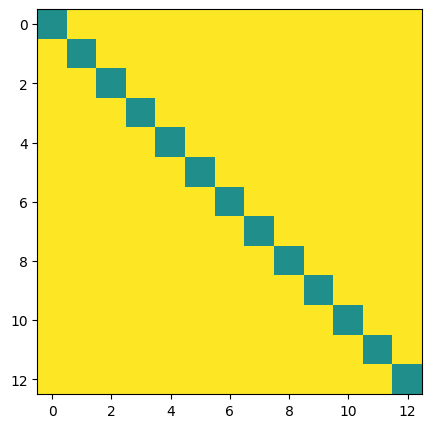

In [19]:
dmat,pol_comp = GenerateRandomWalkPolymers(params,NCELL,NSEG)
plt.figure(figsize=(5,5))
# plt.imshow(xp.asnumpy(xp.median(dmat_ctrl2,axis=2)),aspect='equal', vmin=100, vmax=400)
plt.imshow(xp.asnumpy(dmat),aspect='equal', vmin=-50, vmax=50)
plt.show()

In [20]:
def fmin_func(params,NCELL,NSEG):
    # ---- generate 3d random walk polymers ---- #
    dmatdiff,pol_comp = GenerateRandomWalkPolymers(params,NCELL,NSEG)
    # ---- calculate error ---- #
    error = xp.sum(xp.sum((dmatdiff - dmat_exp)**2))
    # error = xp.sum(xp.sum(xp.abs(dmatdiff - dmatdiff_exp)))
    return error

In [21]:
score = fmin_func(params,NCELL,NSEG)
score

array(1702373.1, dtype=float32)

### optimize 6 paramaters

In [ ]:
## find parameters for a given distance matrix using optuna
NCELL = 50000
cmin = 0.7
cmax = 1.0
def objective(trial):
    inputparams = xp.float32((1.0,
                                1.0,
                                1.0,
                                trial.suggest_float('p0', cmin, cmax),
                                trial.suggest_float('p1', cmin, cmax),
                                trial.suggest_float('p2', cmin, cmax),
                                trial.suggest_float('p3', cmin, cmax),
                                trial.suggest_float('p4', cmin, cmax),
                                trial.suggest_float('p5', cmin, cmax),
                                1.0,
                                1.0,
                                1.0))
    score = fmin_func(inputparams,NCELL,NSEG)
    return score

# 3. Create a study object and optimize the objective function.
start = time.time()
study = optuna.create_study() # put direction='maximize' if you want maximize the score
study = optuna.create_study(sampler=optuna.samplers.TPESampler(prior_weight=500.0))
study.enqueue_trial({'p0':0.8, 'p1':0.8, 'p2':0.8, 'p3':0.8, 'p4':0.8, 'p5':0.8})
study.optimize(objective, n_trials=500)
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

dname = "./drive/MyDrive/RandomWalkFit/output/"
joblib.dump(study, dname+"study.pkl")

[I 2023-02-16 05:51:25,351] A new study created in memory with name: no-name-f10d700b-118f-4be2-80c6-6ca6fe8a35ba
[I 2023-02-16 05:51:25,356] A new study created in memory with name: no-name-68203918-920e-4c16-8404-918b155bc89c
[I 2023-02-16 05:51:25,503] Trial 0 finished with value: 2174.63330078125 and parameters: {'p0': 0.8, 'p1': 0.8, 'p2': 0.8, 'p3': 0.8, 'p4': 0.8, 'p5': 0.8}. Best is trial 0 with value: 2174.63330078125.
[I 2023-02-16 05:51:25,635] Trial 1 finished with value: 2170.00830078125 and parameters: {'p0': 0.7221654939371699, 'p1': 0.9967478561136167, 'p2': 0.9738240361176149, 'p3': 0.9748670937301134, 'p4': 0.9858288137049043, 'p5': 0.9040091034177253}. Best is trial 1 with value: 2170.00830078125.
[I 2023-02-16 05:51:25,730] Trial 2 finished with value: 1801.8779296875 and parameters: {'p0': 0.9791547028978544, 'p1': 0.8294409757568726, 'p2': 0.8571211568010273, 'p3': 0.9065523135869579, 'p4': 0.7485150491058506, 'p5': 0.7086428341781499}. Best is trial 2 with value:

elapsed_time:66.5030198097229[sec]


['./drive/MyDrive/RandomWalkFit/output/study.pkl']

Best trial until now:
 Value:  1235.517578125
 Params: 
    p0: 0.8444977119016688
    p1: 0.8358544858409298
    p2: 0.8049559010401311
    p3: 0.9108213941936101
    p4: 0.9304669339199859
    p5: 0.865164583022966


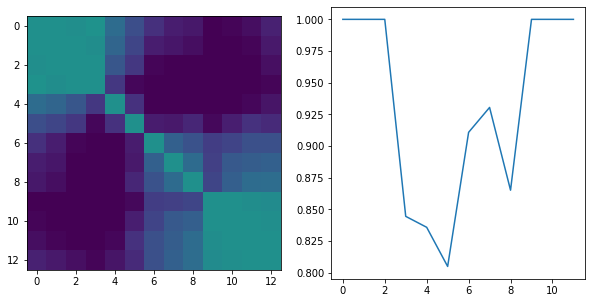

In [ ]:
dname = "./drive/MyDrive/RandomWalkFit/output/"
study_load = joblib.load(dname+"study.pkl")
print("Best trial until now:")
print(" Value: ", study_load.best_trial.value)
print(" Params: ")
for key, value in study_load.best_trial.params.items():
    print(f"    {key}: {value}")

inputparams = xp.float32((1.0,
                            1.0,
                            1.0,
                            study_load.best_trial.params['p0'],
                            study_load.best_trial.params['p1'],
                            study_load.best_trial.params['p2'],
                            study_load.best_trial.params['p3'],
                            study_load.best_trial.params['p4'],
                            study_load.best_trial.params['p5'],
                            1.0,
                            1.0,
                            1.0))
dmatdiff = GenerateRandomWalkPolymers(inputparams,NCELL,NSEG)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(xp.asnumpy(dmatdiff),aspect='equal', vmin=-30, vmax=30)
plt.subplot(1,2,2)
plt.plot(xp.asnumpy(inputparams))
plt.show()


1306.5498


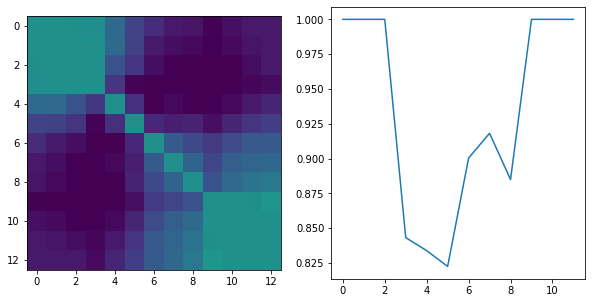

In [ ]:
trials_df = study_load.trials_dataframe()
top10_trials = trials_df.nsmallest(10, 'value')
inputparams = xp.float32((1.0,
                            1.0,
                            1.0,
                            np.mean(top10_trials.params_p0),
                            np.mean(top10_trials.params_p1),
                            np.mean(top10_trials.params_p2),
                            np.mean(top10_trials.params_p3),
                            np.mean(top10_trials.params_p4),
                            np.mean(top10_trials.params_p5),
                            1.0,
                            1.0,
                            1.0))
dmatdiff = GenerateRandomWalkPolymers(inputparams,NCELL,NSEG)
print(xp.sum(xp.sum(xp.abs(dmatdiff - dmatdiff_exp))))
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(xp.asnumpy(dmatdiff),aspect='equal', vmin=-30, vmax=30)
plt.subplot(1,2,2)
plt.plot(xp.asnumpy(inputparams))
plt.show()

### optimize 12 paramaters

In [ ]:
## find parameters for a given distance matrix using optuna
NCELL = 50000
cmin = 0.7
cmax = 1.1
def objective(trial):
    inputparams = xp.float32((trial.suggest_float('p0', cmin, cmax),
                                trial.suggest_float('p1', cmin, cmax),
                                trial.suggest_float('p2', cmin, cmax),
                                trial.suggest_float('p3', cmin, cmax),
                                trial.suggest_float('p4', cmin, cmax),
                                trial.suggest_float('p5', cmin, cmax),
                                trial.suggest_float('p6', cmin, cmax),
                                trial.suggest_float('p7', cmin, cmax),
                                trial.suggest_float('p8', cmin, cmax),
                                trial.suggest_float('p9', cmin, cmax),
                                trial.suggest_float('p10', cmin, cmax),
                                trial.suggest_float('p11', cmin, cmax)))
    score = fmin_func(inputparams,NCELL,NSEG)
    return score

# Create a study object and optimize the objective function.
start = time.time()
study = optuna.create_study(sampler=optuna.samplers.TPESampler(prior_weight=1000.0))
# study.enqueue_trial({'p0':1.0, 'p1':1.0, 'p2':1.0, 'p3':1.0, 'p4':0.8, 'p5':0.8, 'p6':0.8, 'p7':0.8, 'p8':1.0, 'p9':1.0, 'p10':1.0, 'p11':1.0})
study.optimize(objective, n_trials=300)
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

dname = "./drive/MyDrive/RandomWalkFit/output/"
joblib.dump(study, dname+"study.pkl")

[I 2023-02-16 07:02:17,621] A new study created in memory with name: no-name-d0ff6c8f-fb6c-43bd-a188-4f5bf4c9de94
[I 2023-02-16 07:02:17,767] Trial 0 finished with value: 62918.9921875 and parameters: {'p0': 0.9497537513062453, 'p1': 0.7941408405359329, 'p2': 1.07789904045634, 'p3': 0.9996093763552553, 'p4': 0.9729969533368734, 'p5': 1.064360025059599, 'p6': 0.9553784953315718, 'p7': 0.9852773444120895, 'p8': 0.789243211758332, 'p9': 0.8348748905220214, 'p10': 1.0930541341153641, 'p11': 1.0251091954650524}. Best is trial 0 with value: 62918.9921875.
[I 2023-02-16 07:02:17,874] Trial 1 finished with value: 50187.8203125 and parameters: {'p0': 1.0025858190946668, 'p1': 0.7522548024086515, 'p2': 0.9572340256474475, 'p3': 0.9040495720939362, 'p4': 0.9042828613281926, 'p5': 0.9619273226634097, 'p6': 0.7386593328407033, 'p7': 0.9633292179000568, 'p8': 0.9438805233750611, 'p9': 0.8115588531365697, 'p10': 0.8686626013486962, 'p11': 0.7162627917007891}. Best is trial 1 with value: 50187.8203125

elapsed_time:56.03059983253479[sec]


['./drive/MyDrive/RandomWalkFit/output/study.pkl']

Best trial until now:
 Value:  14484.2080078125
 Params: 
    p0: 0.919147283112825
    p1: 0.9600925570852673
    p2: 0.978998786919555
    p3: 0.9348670095469767
    p4: 0.9148255952461967
    p5: 0.7101819645513899
    p6: 0.9217187278508747
    p7: 0.9644616148559445
    p8: 0.9499553095677113
    p9: 0.907661771108298
    p10: 1.0219978040669109
    p11: 0.9626539122478395
1263.2368


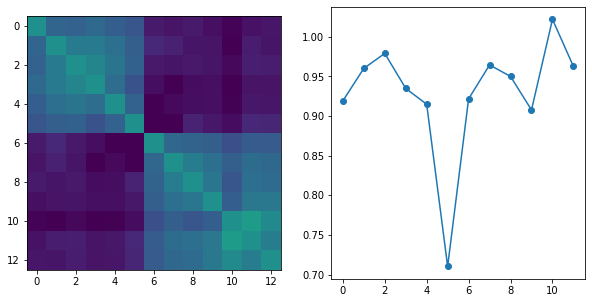

In [ ]:
dname = "./drive/MyDrive/RandomWalkFit/output/"
study_load = joblib.load(dname+"study.pkl")
print("Best trial until now:")
print(" Value: ", study_load.best_trial.value)
print(" Params: ")
for key, value in study_load.best_trial.params.items():
    print(f"    {key}: {value}")

inputparams = xp.float32((study_load.best_trial.params['p0'],
                            study_load.best_trial.params['p1'],
                            study_load.best_trial.params['p2'],
                            study_load.best_trial.params['p3'],
                            study_load.best_trial.params['p4'],
                            study_load.best_trial.params['p5'],
                            study_load.best_trial.params['p6'],
                            study_load.best_trial.params['p7'],
                            study_load.best_trial.params['p8'],
                            study_load.best_trial.params['p9'],
                            study_load.best_trial.params['p10'],
                            study_load.best_trial.params['p11']))
dmatdiff = GenerateRandomWalkPolymers(inputparams,NCELL,NSEG)
print(xp.sum(xp.sum(xp.abs(dmatdiff - dmatdiff_exp))))
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(xp.asnumpy(dmatdiff),aspect='equal', vmin=-30, vmax=30)
plt.subplot(1,2,2)
plt.plot(xp.asnumpy(inputparams),'o-')
# plt.plot(np.log(xp.asnumpy(inputparams)),'o-')
plt.show()


In [ ]:
trials_df = study_load.trials_dataframe()
top10_trials = trials_df.nsmallest(100, 'value')
inputparams = xp.float32((np.mean(top10_trials.params_p0),
                            np.mean(top10_trials.params_p1),
                            np.mean(top10_trials.params_p2),
                            np.mean(top10_trials.params_p3),
                            np.mean(top10_trials.params_p4),
                            np.mean(top10_trials.params_p5),
                            np.mean(top10_trials.params_p6),
                            np.mean(top10_trials.params_p7),
                            np.mean(top10_trials.params_p8),
                            np.mean(top10_trials.params_p9),
                            np.mean(top10_trials.params_p10),
                            np.mean(top10_trials.params_p11)))
dmatdiff = GenerateRandomWalkPolymers(inputparams,NCELL,NSEG)
print(xp.sum(xp.sum(xp.abs(dmatdiff - dmatdiff_exp))))
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(xp.asnumpy(dmatdiff),aspect='equal', vmin=-30, vmax=30)
plt.subplot(1,2,2)
plt.plot(xp.asnumpy(inputparams),'o-')
plt.show()
top10_trials

### 12 params N = 10

In [58]:
## find parameters for a given distance matrix using optuna
NCELL = 50000
cmin = 0.5
cmax = 1.5
def objective(trial):
    inputparams = xp.float32((trial.suggest_float('p0', cmin, cmax),
                                trial.suggest_float('p1', cmin, cmax),
                                trial.suggest_float('p2', cmin, cmax),
                                trial.suggest_float('p3', cmin, cmax),
                                trial.suggest_float('p4', cmin, cmax),
                                trial.suggest_float('p5', cmin, cmax),
                                trial.suggest_float('p6', cmin, cmax),
                                trial.suggest_float('p7', cmin, cmax),
                                trial.suggest_float('p8', cmin, cmax),
                                trial.suggest_float('p9', cmin, cmax),
                                trial.suggest_float('p10', cmin, cmax),
                                trial.suggest_float('p11', cmin, cmax)))
    score = fmin_func(inputparams,NCELL,NSEG)
    return score
Nfit = 10
dname = "./drive/MyDrive/RandomWalkFit/output/avg_multiple_study"+conditionname+"/"
start = time.time()
for ii in range(0,Nfit):
    # Create a study object and optimize the objective function.
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(prior_weight=1000.0))
    study.optimize(objective, n_trials=300)
    joblib.dump(study, dname+"study_N"+str(ii)+".pkl")

elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")


[I 2023-08-20 00:12:59,083] A new study created in memory with name: no-name-d7ac3e12-dd66-4525-8954-e0b0b89f07c0
[I 2023-08-20 00:12:59,161] Trial 0 finished with value: 617976.0 and parameters: {'p0': 0.7039391337291415, 'p1': 0.5970232749751663, 'p2': 0.8141414051495381, 'p3': 1.2998031440192155, 'p4': 0.6433594953708872, 'p5': 0.898303259560609, 'p6': 0.953029207916382, 'p7': 0.6318168164902535, 'p8': 0.7838279365908145, 'p9': 1.213083158344174, 'p10': 1.018861758853813, 'p11': 1.2246465027731852}. Best is trial 0 with value: 617976.0.
[I 2023-08-20 00:12:59,236] Trial 1 finished with value: 685865.875 and parameters: {'p0': 0.5252187962575, 'p1': 1.1040784998704707, 'p2': 1.4266125422885827, 'p3': 0.6539993069512801, 'p4': 0.8460464263841365, 'p5': 0.6666111305908708, 'p6': 1.2850842763076034, 'p7': 0.6454117010116178, 'p8': 1.4535666368559665, 'p9': 1.3583037142247265, 'p10': 0.7437602521410269, 'p11': 0.8478762381223508}. Best is trial 0 with value: 617976.0.
[I 2023-08-20 00:12

elapsed_time:362.2187180519104[sec]


In [60]:
# import study results

conditionname = "_reactivated"
# conditionname = "_irreversible"
# conditionname = "_KRAB-5days"
# conditionname = "_KRAB147-1day"
Nfit = 10
params = xp.zeros((NSEG-1,Nfit)).astype('f')
dmatdiff_all = xp.zeros((NSEG,NSEG,Nfit)).astype('f')
dname = "./drive/MyDrive/RandomWalkFit/output/avg_multiple_study"+conditionname+"/"
for ii in range(0,Nfit):
    study_load = joblib.load(dname+"study_N"+str(ii)+".pkl")
    params[:,ii] = xp.array([study_load.best_trial.params['p0'],
                                study_load.best_trial.params['p1'],
                                study_load.best_trial.params['p2'],
                                study_load.best_trial.params['p3'],
                                study_load.best_trial.params['p4'],
                                study_load.best_trial.params['p5'],
                                study_load.best_trial.params['p6'],
                                study_load.best_trial.params['p7'],
                                study_load.best_trial.params['p8'],
                                study_load.best_trial.params['p9'],
                                study_load.best_trial.params['p10'],
                                study_load.best_trial.params['p11']])

inputparams = xp.median(params,axis=1)
dmat,pol_comp = GenerateRandomWalkPolymers(inputparams,NCELL,NSEG)
np.savetxt(dname+'fittedparams.csv', xp.asnumpy(params), delimiter=',')

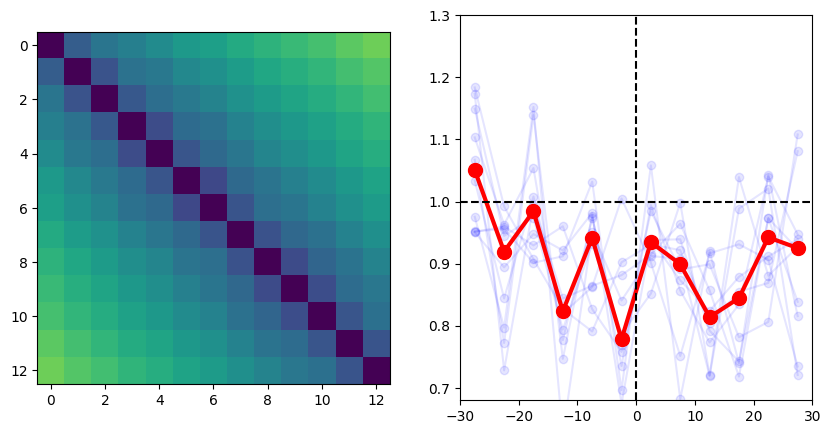

In [50]:
xax = np.linspace(-27.5,27.5,12)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(xp.asnumpy(dmat),aspect='equal', vmin=0, vmax=500)
plt.subplot(1,2,2)
plt.plot(xax,xp.asnumpy(params),'bo-',alpha=0.1)
plt.plot(xax,xp.asnumpy(inputparams),'ro-',markersize=10,linewidth=3)
plt.plot([0,0],[0.68,1.3],'k--')
plt.plot([-30,30],[1.0,1.0],'k--')
# plt.plot(np.log(xp.asnumpy(inputparams)),'o-')
plt.xlim([-30,30])
plt.ylim([0.68,1.3])
plt.show()


### comparison between control and each condition

In [51]:
# import study results and calc diff

# conditionname = "_reactivated"
# conditionname = "_irreversible"
# conditionname = "_KRAB-5days"
conditionname = "_KRAB-nodox"
dname = "./drive/MyDrive/RandomWalkFit/output/avg_multiple_study"+conditionname+"/"
fname = "fittedparams.csv"
params = xp.array(np.loadtxt(dname+fname,delimiter=",").astype('f'))
inputparams = xp.median(params,axis=1)
dmat_ctrl,pol_ctrl = GenerateRandomWalkPolymers(inputparams,NCELL,NSEG)

conditionname = "_KRAB-5days"
dname = "./drive/MyDrive/RandomWalkFit/output/avg_multiple_study"+conditionname+"/"
fname = "fittedparams.csv"
params = xp.array(np.loadtxt(dname+fname,delimiter=",").astype('f'))
inputparams = xp.median(params,axis=1)
dmat,pol_comp = GenerateRandomWalkPolymers(inputparams,NCELL,NSEG)



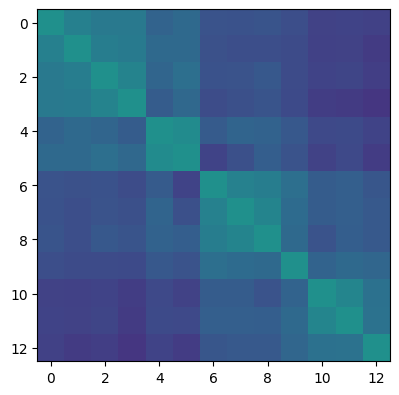

In [52]:
xax = np.linspace(-27.5,27.5,12)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(xp.asnumpy(dmat-dmat_ctrl),aspect='equal', vmin=-50, vmax=50)
# plt.subplot(1,2,2)
# plt.plot(xax,xp.asnumpy(params),'bo-',alpha=0.1)
# plt.plot(xax,xp.asnumpy(inputparams),'ro-',markersize=10,linewidth=3)
# plt.plot([0,0],[0.68,1.3],'k--')
# plt.plot([-30,30],[1.0,1.0],'k--')
# # plt.plot(np.log(xp.asnumpy(inputparams)),'o-')
# plt.xlim([-30,30])
# plt.ylim([0.68,1.3])
plt.show()


In [53]:
pol_ctrl_N = pol_ctrl - xp.repeat(xp.mean(pol_ctrl,axis=0).reshape(1,3,NCELL),NSEG,axis=0)
Rg_ctrl = xp.asnumpy(xp.sqrt(xp.mean(xp.sum(pol_ctrl_N**2,axis=1),axis=0)))
pol_comp_N = pol_comp - xp.repeat(xp.mean(pol_comp,axis=0).reshape(1,3,NCELL),NSEG,axis=0)
Rg_comp = xp.asnumpy(xp.sqrt(xp.mean(xp.sum(pol_comp_N**2,axis=1),axis=0)))


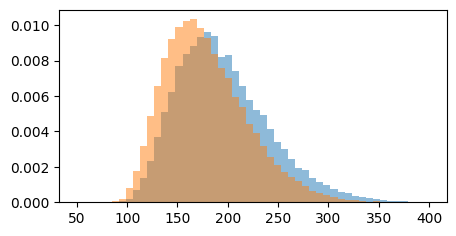

In [54]:
plt.figure(figsize=(5,2.5))
plt.hist(Rg_ctrl,bins=50,range=(50,400),alpha=0.5,density=True,stacked=True)
plt.hist(Rg_comp,bins=50,range=(50,400),alpha=0.5,density=True,stacked=True)
plt.show()

### curve_fit function

In [ ]:
out = fitfunc(xgv,1.0, 1.0, 1.0, 1.0, 0.8, 0.8, 0.8, 0.8, 1.0, 1.0, 1.0, 1.0)
np.sum((out - Dfit)**2)

26746.197

In [ ]:
def fitfunc(xgv,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11):
    params = xp.float32((p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11))
    out = GenerateRandomWalkPolymers(params,NCELL,NSEG)
    out = xp.asnumpy(out.reshape(NSEG**2,1))
    out = out.ravel()
    return out

# フィッティングの初期パラメタ
params_init = np.array([1.0, 1.0, 1.0, 1.0, 0.8, 0.8, 0.8, 0.8, 1.0, 1.0, 1.0, 1.0])
Dfit = xp.asnumpy(dmatdiff_exp.reshape(NSEG**2,1))
Dfit = Dfit.ravel()
xax = np.ones((NSEG,1)).astype('f')
for ii in range(0,NSEG):
    xax[ii] = ii
xmat = np.repeat(xax,NSEG,axis=0)
ymat = np.repeat(xax,NSEG,axis=1).T.reshape(NSEG**2,1)
xgv = (xmat,ymat)

# 最適化実行
popt, pcov = optimize.curve_fit(fitfunc, xgv, Dfit, p0 = params_init)
print("parameter: ", popt)


In [ ]:
# fitting function
def fitfunc(p):
    params = xp.float32((p[0],p[1],p[2],p[3],p[4],p[5],p[6],p[7],p[8],p[9],p[10],p[11]))
    out = GenerateRandomWalkPolymers(params,NCELL,NSEG)
    out = xp.asnumpy(out.reshape(NSEG**2,1))
    out = np.sum(np.abs(Dfit - out.ravel()))
    return out

# reshape data
params_init = np.array([1.0, 1.0, 1.0, 1.0, 0.8, 0.8, 0.8, 0.8, 1.0, 1.0, 1.0, 1.0])
Dfit = xp.asnumpy(dmatdiff_exp.reshape(NSEG**2,1))
Dfit = Dfit.ravel()
bounds = [(0.6, 1.1)]*12
# optimize
le_lsq = optimize.basinhopping(fitfunc, params_init, niter=10, stepsize=0.1, minimizer_kwargs={"bounds": bounds})



In [ ]:
le_lsq

                        fun: 1573.6849
 lowest_optimization_result:       fun: 1573.6849
 hess_inv: <12x12 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.91223136e+08,  8.41258547e+09,  9.52874803e+09,  4.88645018e+09,
        1.47415532e+10,  1.35944458e+10,  1.22829957e+10,  9.62955366e+09,
        9.58719488e+09,  1.92853893e+10,  9.15469926e+09,  1.85649050e+10])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 273
      nit: 0
     njev: 21
   status: 2
  success: False
        x: array([1. , 1. , 1. , 1. , 0.8, 0.8, 0.8, 0.8, 1. , 1. , 1. , 1. ])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 4
                       nfev: 3744
                        nit: 10
                       njev: 288
                          x: array([1. , 1. , 1. , 1. , 0.8, 0.8, 0.8, 0.8, 1. , 1. , 1. , 1. ])

In [ ]:
dname = "./drive/MyDrive/output/"
study_load = joblib.load(dname+"study_singlefb_3.pkl")
print("Best trial until now:")
print(" Value: ", study_load.best_trial.value)
print(" Params: ")
for key, value in study_load.best_trial.params.items():
    print(f"    {key}: {value}")
onsiteinhibit = 0.6624;
kba = 0.001;
Km = 50.0; kcat = 0.94*3600*0.65*onsiteinhibit; K0H1 = 1.0; # HDAC

NCELL = 20000
init = -1.0 *xp.ones((NCELL,NNUC)).astype('f')
inputparams = xp.float32((study_load.best_trial.params['p0'],
                            0.0,
                            0.0,
                            0.0,
                            study_load.best_trial.params['p2'],
                            study_load.best_trial.params['p3'],
                            study_load.best_trial.params['p3'],
                            0.0,
                            0.0,
                            kba,Km,kcat,K0H1))

start = time.time()
out = fmin_func(inputparams,NCELL,NNUC) # fmin_func that is defined in the other cells
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]") # 1298 sec for sutdy no2

Best trial until now:
 Value:  6.310842872753292
 Params: 
    p0: 0.00805544445759934
    p2: 1.0062900429474178
    p3: 0.9982413957834325
elapsed_time:1069.6870222091675[sec]


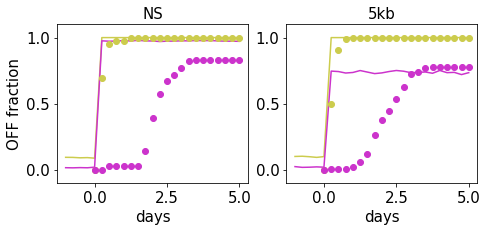

In [ ]:
## calculate quad
NCELLq1 = xp.int64(NCELL/4)
NCELLq2 = xp.int64(NCELL/4*2)
NCELLq3 = xp.int64(NCELL/4*3)
cellidx = ((0,NCELLq1),(NCELLq1,NCELLq2),(NCELLq2,NCELLq3),(NCELLq3,NCELL))
mchidx = ((pRSV,mCh_e),(pRSV1p2,mCh_e1p2),(pRSV3,mCh_e3),(pRSV5kb,mCh_e5kb))
quad = xp.empty((4,out.shape[2],1)).astype('f');
for i in range(0,len(cellidx)):
    res = quadrant_forfig(out[cellidx[i][0]:cellidx[i][1],:,:],threshC,threshM,mchidx[i])
    quad = xp.concatenate((quad,res),axis=2)
quad = quad[:,:,1:]

quad = quad[:,:,[0,3]] # look at only NS and 5kb

## plot timecourse
colors = ((.8, .2 ,.8),(.8, .5 ,.3),(.8, .8 ,.3),(.6, .6 ,.6))
titles = ["NS","5kb"]
lst = ("-","-.","--",":")
# time_sim = np.linspace(0,20.0,out.shape[2]);
mpl.rcParams['pdf.fonttype'] = 42
f = plt.figure(figsize=(8,4))
for i in range(0,2):
  plt.subplot(1,2,i+1)
  time_sim = np.linspace(-1.0,5.0,25);
  cit = xp.asnumpy(1-quad[1,0:len(time_sim),i]-quad[2,0:len(time_sim),i])
  mch = xp.asnumpy(1-quad[0,0:len(time_sim),i]-quad[1,0:len(time_sim),i])
  plt.plot(time_sim,cit,linestyle=lst[0],marker="",color=colors[2])
  plt.plot(time_sim,mch,linestyle=lst[0],marker="",color=colors[0])

  time_sim = np.linspace(0.0,5.0,21);
  plt.plot(time_sim,xp.asnumpy(cit_exp[:,i]),linestyle="",marker="o",color=colors[2])
  plt.plot(time_sim,xp.asnumpy(mch_exp[:,i]),linestyle="",marker="o",color=colors[0])

  plt.xlabel("days",fontsize=15)
  if i ==0:
    plt.ylabel("OFF fraction",fontsize=15)

  plt.title(titles[i],fontsize=15)
  # plt.legend(["Cit sim","mCh sim","Cit exp","mCh exp"],loc=(1.04,-0.1),fontsize=15)
  plt.yticks([0,0.5,1.0])
  plt.xticks([0,2.5,5.0])
  plt.ylim([-0.1,1.1])
  plt.tick_params(labelsize=15)
  plt.subplots_adjust(left=0.25, right=0.98, bottom=0.4, top=0.95)
  mpl.rcParams['pdf.fonttype'] = 42
# f.savefig('./drive/My Drive/output/plot_offfractionVStime_K562HDAC_2.pdf',transparent=True)

### tetO micro states

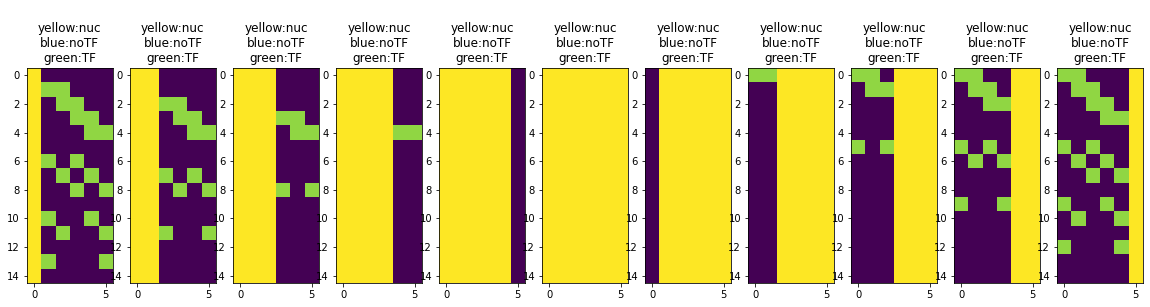

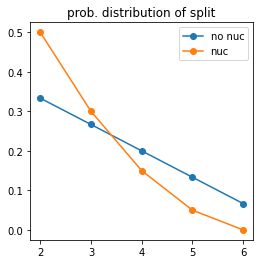

In [ ]:
# list up n2 binding patterns with nucleosomes
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

nucleosomeboundpattern = np.array([[1,0,0,0,0,0],[1,1,0,0,0,0],[1,1,1,0,0,0],[1,1,1,1,0,0],[1,1,1,1,1,0],[1,1,1,1,1,1],[0,1,1,1,1,1],[0,0,1,1,1,1],[0,0,0,1,1,1],[0,0,0,0,1,1],[0,0,0,0,0,1]])
n2boundpattern = np.array([[1,1,0,0,0,0],[0,1,1,0,0,0],[0,0,1,1,0,0],[0,0,0,1,1,0],[0,0,0,0,1,1],[1,0,1,0,0,0],[0,1,0,1,0,0],[0,0,1,0,1,0],[0,0,0,1,0,1],[1,0,0,1,0,0],[0,1,0,0,1,0],[0,0,1,0,0,1],[1,0,0,0,1,0],[0,1,0,0,0,1],[1,0,0,0,0,1]])
n2bound_all = np.ones((n2boundpattern.shape[0],nucleosomeboundpattern.shape[0]))

plt.figure(figsize=(20,5))
for ii in range(0,nucleosomeboundpattern.shape[0]):
    plt.subplot(1,nucleosomeboundpattern.shape[0],ii+1)
    nucbound = np.repeat(nucleosomeboundpattern[ii:(ii+1),:],n2boundpattern.shape[0],axis=0)
    n2bound = n2boundpattern*(nucbound == 0) # TF binds empty tetO
    n2bound[np.sum(n2bound,axis=1) == 1,:] = 0 # remove only n1 bound
    n2bound_all[:,ii] = np.sum(n2bound,axis=1) == 2
    # -- visualization -- #
    n2bound = n2bound+nucbound*2
    plt.imshow(n2bound,aspect='equal', vmin=0, vmax=1.2)
    plt.title('\n'+'yellow:nuc'+'\n'+'blue:noTF'+'\n'+'green:TF')
plt.show()

# plot probability of each split
n2bound_sum = np.sum(n2bound_all,axis=1)
n2bound_sum = n2bound_sum/np.sum(n2bound_sum)
split_nuc = np.array([n2bound_sum[0:5].sum(),n2bound_sum[5:9].sum(),n2bound_sum[9:12].sum(),n2bound_sum[12:14].sum(),n2bound_sum[14:15].sum()])
split_nonuc = np.array([0.3333,0.2667,0.2000,0.1333,0.0667])

plt.figure(figsize=(4,4))
plt.plot(range(2,7),split_nonuc,'o-')
plt.plot(range(2,7),split_nuc,'o-')
plt.title('prob. distribution of split')
plt.legend(['no nuc','nuc'])
plt.show()

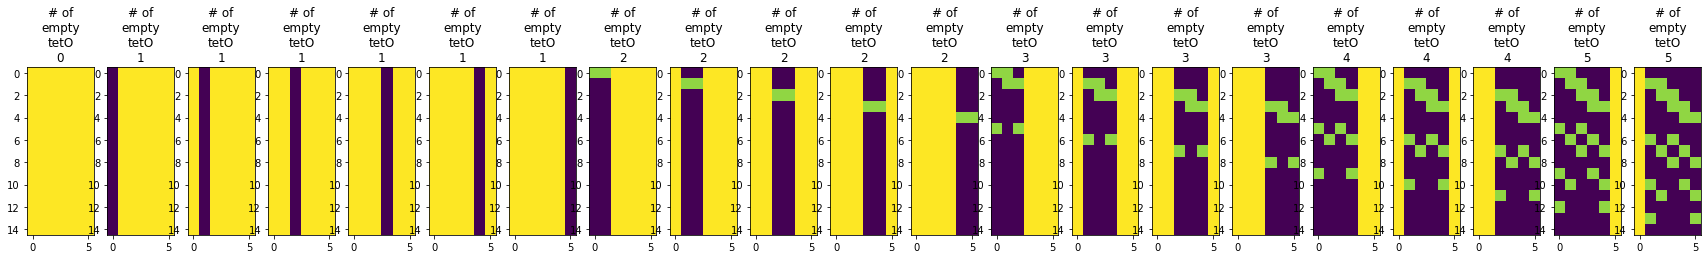

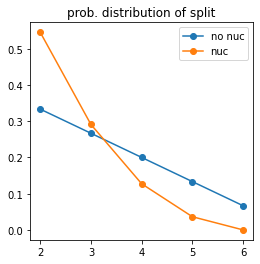

In [ ]:
# list up n2 binding patterns with nucleosomes
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

nucleosomeboundpattern = np.array([ [1,1,1,1,1,1],
                                    [0,1,1,1,1,1],
                                    [1,0,1,1,1,1],
                                    [1,1,0,1,1,1],
                                    [1,1,1,0,1,1],
                                    [1,1,1,1,0,1],
                                    [1,1,1,1,1,0],
                                    [0,0,1,1,1,1],
                                    [1,0,0,1,1,1],
                                    [1,1,0,0,1,1],
                                    [1,1,1,0,0,1],
                                    [1,1,1,1,0,0],
                                    [0,0,0,1,1,1],
                                    [1,0,0,0,1,1],
                                    [1,1,0,0,0,1],
                                    [1,1,1,0,0,0],
                                    [0,0,0,0,1,1],
                                    [1,0,0,0,0,1],
                                    [1,1,0,0,0,0],
                                    [0,0,0,0,0,1],
                                    [1,0,0,0,0,0]])
n2boundpattern = np.array([[1,1,0,0,0,0],[0,1,1,0,0,0],[0,0,1,1,0,0],[0,0,0,1,1,0],[0,0,0,0,1,1],[1,0,1,0,0,0],[0,1,0,1,0,0],[0,0,1,0,1,0],[0,0,0,1,0,1],[1,0,0,1,0,0],[0,1,0,0,1,0],[0,0,1,0,0,1],[1,0,0,0,1,0],[0,1,0,0,0,1],[1,0,0,0,0,1]])
n2bound_all = np.ones((n2boundpattern.shape[0],nucleosomeboundpattern.shape[0]))

plt.figure(figsize=(30,5))
for ii in range(0,nucleosomeboundpattern.shape[0]):
    figax = nucleosomeboundpattern.shape[0]
    plt.subplot(1,figax,ii+1)
    nucbound = np.repeat(nucleosomeboundpattern[ii:(ii+1),:],n2boundpattern.shape[0],axis=0)
    n2bound = n2boundpattern*(nucbound == 0) # TF binds empty tetO
    n2bound[np.sum(n2bound,axis=1) == 1,:] = 0 # remove only n1 bound
    n2bound_all[:,ii] = np.sum(n2bound,axis=1) == 2
    # -- visualization -- #
    n2bound = n2bound+nucbound*2 # make nuc bound site yellow
    plt.imshow(n2bound, vmin=0, vmax=1.2)
    plt.title('# of'+'\n'+'empty'+'\n'+'tetO'+'\n'+str((nucbound[0,:] == 0).sum()))
plt.show()

# plot probability of each split
n2bound_sum = np.sum(n2bound_all,axis=1)
n2bound_sum = n2bound_sum/np.sum(n2bound_sum)
split_nuc = np.array([n2bound_sum[0:5].sum(),n2bound_sum[5:9].sum(),n2bound_sum[9:12].sum(),n2bound_sum[12:14].sum(),n2bound_sum[14:15].sum()])
split_nonuc = np.array([0.3333,0.2667,0.2000,0.1333,0.0667])

plt.figure(figsize=(4,4))
plt.plot(range(2,7),split_nonuc,'o-')
plt.plot(range(2,7),split_nuc,'o-')
plt.title('prob. distribution of split')
plt.legend(['no nuc','nuc'])
plt.show()

In [ ]:
np.sum(n2bound_all,axis=1)

array([4., 7., 8., 7., 4., 3., 5., 5., 3., 2., 3., 2., 1., 1., 0.])